In [1]:
import pandas as pnd
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors, datasets
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier
from sklearn import svm
import random
import operator

from sklearn.model_selection import KFold

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn import tree
import seaborn as sns

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# function for confusion matrix building
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

def visualize_tree(tr, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        tree.export_graphviz(tr, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]

In [3]:
# add the rows names
import pandas as pnd
header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels','diagnosis']

# read csv file with Cleveland heart diseases data
heart = pnd.read_csv("New_Heart_disease.csv", names=header_row)
heart[:5]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,diagnosis
0,63,1,1,145,233,1,2,150,0,2.3,3,0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0


In [4]:
# get statistics values
heart.describe()

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,diagnosis
count,801.000000,801.000000,801.00000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,54.578027,0.682896,3.15980,131.871411,248.485643,0.152310,1.026217,149.855181,0.327091,1.064170,1.604245,0.675406,0.938826
std,8.954564,0.465639,0.95887,17.754498,52.495834,0.359545,0.995270,22.763106,0.469444,1.164089,0.622039,0.944461,1.234910
min,29.000000,0.000000,1.00000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,3.00000,120.000000,212.000000,0.000000,0.000000,134.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.00000,130.000000,243.000000,0.000000,2.000000,153.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.00000,140.000000,277.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,2.000000
max,77.000000,1.000000,4.00000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,4.000000


In [5]:
# get number of people with symptom X_k
names_descr = dict()
categorical_columns = ["sex", "chest_pain", "fasting_blood_sugar", "electrocardiographic", "induced_angina", "slope", "vessels", \
                        "diagnosis"]
for c in categorical_columns:
    print  (heart.groupby([c])["age"].count())

sex
0    254
1    547
Name: age, dtype: int64
chest_pain
1     62
2    128
3    231
4    380
Name: age, dtype: int64
fasting_blood_sugar
0    679
1    122
Name: age, dtype: int64
electrocardiographic
0    386
1      8
2    407
Name: age, dtype: int64
induced_angina
0    539
1    262
Name: age, dtype: int64
slope
1    376
2    366
3     59
Name: age, dtype: int64
vessels
0    472
1    174
2     98
3     57
Name: age, dtype: int64
diagnosis
0    435
1    145
2     92
3     93
4     36
Name: age, dtype: int64


In [6]:
# we have unknown values '?'
# change unrecognized value '?' into mean value through the column
for c in heart.columns[:-1]:
    heart[c] = heart[c].apply(lambda x: heart[heart[c]!='?'][c].astype(float).mean() if x == "?" else x)
    heart[c] = heart[c].astype(float)
    

In [7]:
# print the types of heart disease
set(heart.loc[:, "diagnosis"].values)

{0, 1, 2, 3, 4}

In [8]:
heart_d = heart[heart["diagnosis"] >= 1 ]
print ("Minimum age to Maximum age per disease type")

heart_d.groupby(["diagnosis", ])["age"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis", ])["age"].max().astype(str)

Minimum age to Maximum age per disease type


diagnosis
1    35.0, 70.0
2    42.0, 69.0
3    39.0, 70.0
4    38.0, 77.0
Name: age, dtype: object

<AxesSubplot:xlabel='age'>

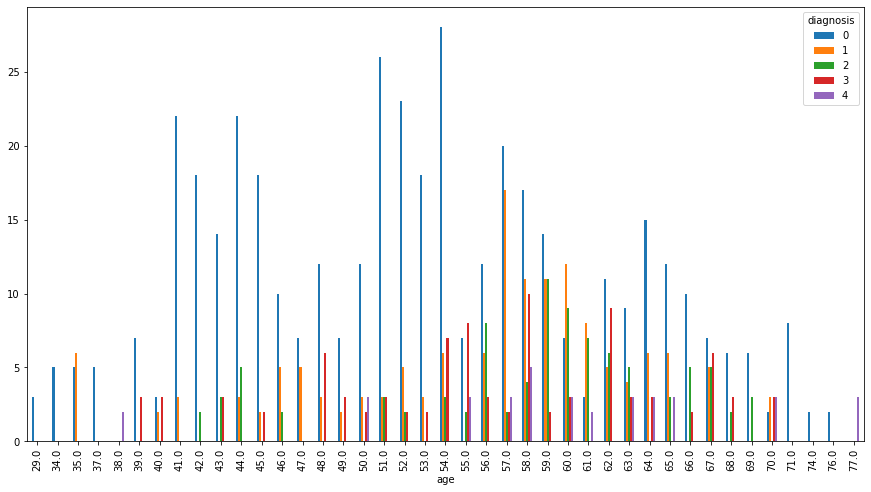

In [9]:
xyz = pnd.crosstab(heart.age,heart.diagnosis)
xyz.plot(kind='bar',stacked=False,figsize=(15,8))

In [10]:
print ("Count each sex per heart disease type")
heart_d.groupby(["diagnosis", "sex"])["age"].count()

Count each sex per heart disease type


diagnosis  sex
1          0.0     22
           1.0    123
2          0.0     19
           1.0     73
3          0.0     18
           1.0     75
4          0.0      6
           1.0     30
Name: age, dtype: int64

In [11]:
abc = pnd.crosstab(heart['sex'],heart['diagnosis'])
abc

diagnosis,0,1,2,3,4
sex,,,,,
0.0,189,22,19,18,6
1.0,246,123,73,75,30


<AxesSubplot:xlabel='sex'>

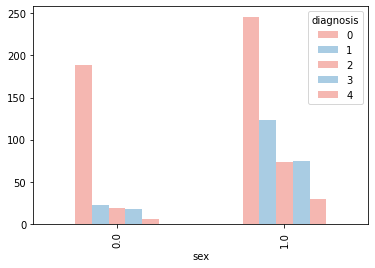

In [12]:
abc.plot(kind='bar', stacked=False, color=['#f5b7b1','#a9cce3'])

In [13]:
print ("Count each chest pain value per heart disease type")
heart_d.groupby(["diagnosis", "chest_pain"])["age"].count()

Count each chest pain value per heart disease type


diagnosis  chest_pain
1          1.0           13
           2.0           15
           3.0           25
           4.0           92
2          1.0            2
           2.0            3
           3.0           11
           4.0           76
3          2.0            5
           3.0           12
           4.0           76
4          1.0            2
           3.0            3
           4.0           31
Name: age, dtype: int64

In [14]:
print ("Minimum blood pressure to Maximum  blood pressure per disease type")

heart_d.groupby(["diagnosis"])["blood pressure"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis"])["blood pressure"].max().astype(str)

Minimum blood pressure to Maximum  blood pressure per disease type


diagnosis
1    108.0, 192.0
2    100.0, 180.0
3    100.0, 200.0
4    112.0, 165.0
Name: blood pressure, dtype: object

In [15]:
print ("Minimum serum_cholestoral to Maximum serum_cholestoral per disease type")
heart_d.groupby(["diagnosis"])["serum_cholestoral"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis"])["serum_cholestoral"].max().astype(str)

Minimum serum_cholestoral to Maximum serum_cholestoral per disease type


diagnosis
1    149.0, 335.0
2    169.0, 409.0
3    131.0, 353.0
4    166.0, 407.0
Name: serum_cholestoral, dtype: object

In [16]:
print ("Count each fasting_blood_sugar per heart disease type")
heart_d.groupby(["diagnosis", "fasting_blood_sugar"])["age"].count()

Count each fasting_blood_sugar per heart disease type


diagnosis  fasting_blood_sugar
1          0.0                    136
           1.0                      9
2          0.0                     70
           1.0                     22
3          0.0                     72
           1.0                     21
4          0.0                     33
           1.0                      3
Name: age, dtype: int64

In [17]:
print ("Count each electrocardiographic per heart disease type")
heart_d.groupby(["diagnosis", "electrocardiographic"])["age"].count()

Count each electrocardiographic per heart disease type


diagnosis  electrocardiographic
1          0.0                     59
           2.0                     86
2          0.0                     46
           1.0                      2
           2.0                     44
3          0.0                     32
           1.0                      2
           2.0                     59
4          0.0                      5
           1.0                      2
           2.0                     29
Name: age, dtype: int64

In [18]:
print ("Minimum max_heart_rate to Maximum max_heart_rate per disease type")

heart_d.groupby(["diagnosis"])["max_heart_rate"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis"])["max_heart_rate"].max().astype(str)

Minimum max_heart_rate to Maximum max_heart_rate per disease type


diagnosis
1     88.0, 195.0
2     71.0, 170.0
3     90.0, 173.0
4    114.0, 182.0
Name: max_heart_rate, dtype: object

In [19]:
print ("Count  induced_angina per heart disease type")
heart_d.groupby(["diagnosis", "induced_angina"])["age"].count()

Count  induced_angina per heart disease type


diagnosis  induced_angina
1          0.0               79
           1.0               66
2          0.0               36
           1.0               56
3          0.0               33
           1.0               60
4          0.0               20
           1.0               16
Name: age, dtype: int64

In [20]:
print ("Count  mean ST_depression per heart disease type")
heart_d.groupby(["diagnosis"])["ST_depression"].mean()

Count  mean ST_depression per heart disease type


diagnosis
1    1.052414
2    1.746739
3    2.051613
4    2.230556
Name: ST_depression, dtype: float64

In [21]:
print ("Count slope per heart disease type")
heart_d.groupby(["diagnosis", "slope"])["age"].count()

Count slope per heart disease type


diagnosis  slope
1          1.0      58
           2.0      81
           3.0       6
2          1.0      17
           2.0      68
           3.0       7
3          1.0      16
           2.0      62
           3.0      15
4          1.0       3
           2.0      28
           3.0       5
Name: age, dtype: int64

In [22]:
print ("Count  mean vessels per heart disease type")
heart_d.groupby(["diagnosis"])["vessels"].mean()

Count  mean vessels per heart disease type


diagnosis
1    0.737931
2    1.271739
3    1.430108
4    1.722222
Name: vessels, dtype: float64

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'chest_pain'}>,
        <AxesSubplot:title={'center':'blood pressure'}>],
       [<AxesSubplot:title={'center':'serum_cholestoral'}>,
        <AxesSubplot:title={'center':'fasting_blood_sugar'}>,
        <AxesSubplot:title={'center':'electrocardiographic'}>,
        <AxesSubplot:title={'center':'max_heart_rate'}>],
       [<AxesSubplot:title={'center':'induced_angina'}>,
        <AxesSubplot:title={'center':'ST_depression'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'vessels'}>],
       [<AxesSubplot:title={'center':'diagnosis'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

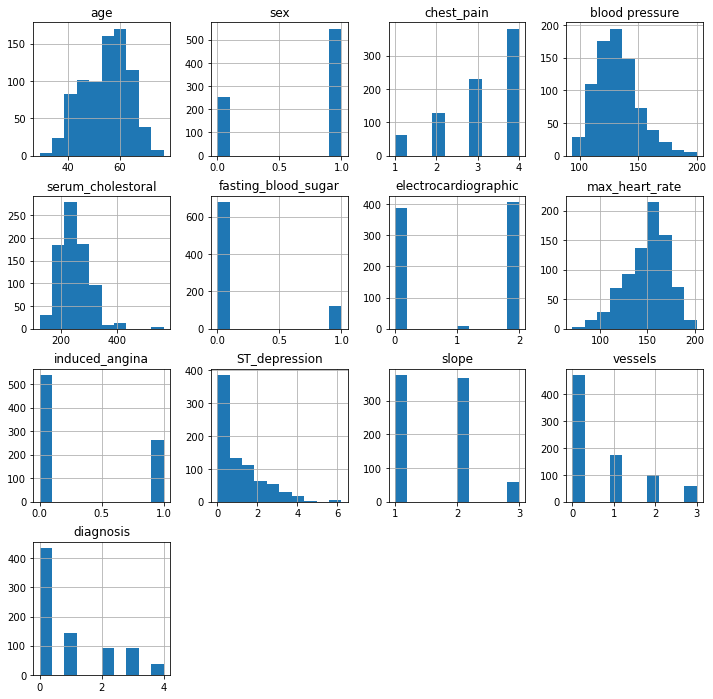

In [23]:
heart.hist(figsize=(12,12))

In [24]:
# if "diagnosis" == 0, member does not have disease A - we put 0
# if "diagnosis" >= 1, member possess the disease A - we put 1
#heart.loc[:, "diag_int"] = heart.loc[:, "diagnosis"].apply(lambda x: 1 if x >= 1 else 0)
heart.loc[:, "diag_int"] = heart.loc[:, "diagnosis"]

In [25]:
# create the normalizer and fit it 
preprocessing.Normalizer().fit_transform(heart)

array([[0.19745017, 0.00313413, 0.00313413, ..., 0.        , 0.        ,
        0.        ],
       [0.19057927, 0.00284447, 0.01137787, ..., 0.0085334 , 0.00568893,
        0.00568893],
       [0.22584443, 0.00337081, 0.01348325, ..., 0.00674162, 0.00337081,
        0.00337081],
       ...,
       [0.21306805, 0.00373804, 0.01121411, ..., 0.00373804, 0.        ,
        0.        ],
       [0.17143702, 0.        , 0.00803611, ..., 0.        , 0.        ,
        0.        ],
       [0.14800421, 0.00344196, 0.01376783, ..., 0.        , 0.        ,
        0.        ]])

In [26]:
# split dataset into train and test
heart_train, heart_test, goal_train, goal_test = model_selection.train_test_split(heart.loc[:,'age':'vessels'], \
                                                 heart.loc[:,'diag_int'], test_size=0.33, random_state=0) 

In [27]:
# calculate the correlation between features

corr = heart.corr()
heart.corr()

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,diagnosis,diag_int
age,1.000000,-0.096586,0.103947,0.286409,0.230790,0.120156,0.139536,-0.389459,0.097402,0.198041,0.163201,0.371322,0.234593,0.234593
sex,-0.096586,1.000000,0.007249,-0.067687,-0.209439,0.049925,0.012567,-0.036415,0.160580,0.092702,0.036589,0.089685,0.218387,0.218387
chest_pain,0.103947,0.007249,1.000000,-0.046517,0.078592,-0.063435,0.063715,-0.325027,0.369700,0.196744,0.139694,0.229882,0.411519,0.411519
blood pressure,0.286409,-0.067687,-0.046517,1.000000,0.140862,0.169515,0.137920,-0.048008,0.066242,0.196871,0.123510,0.098069,0.162410,0.162410
serum_cholestoral,0.230790,-0.209439,0.078592,0.140862,1.000000,0.011904,0.172276,-0.004805,0.052080,0.034402,-0.017266,0.120014,0.071011,0.071011
fasting_blood_sugar,0.120156,0.049925,-0.063435,0.169515,0.011904,1.000000,0.051704,0.015986,0.008108,-0.001878,0.046289,0.142091,0.037903,0.037903
electrocardiographic,0.139536,0.012567,0.063715,0.137920,0.172276,0.051704,1.000000,-0.075200,0.061884,0.110536,0.139944,0.126087,0.183355,0.183355
max_heart_rate,-0.389459,-0.036415,-0.325027,-0.048008,-0.004805,0.015986,-0.075200,1.000000,-0.376902,-0.347039,-0.382243,-0.266389,-0.417510,-0.417510
induced_angina,0.097402,0.160580,0.369700,0.066242,0.052080,0.008108,0.061884,-0.376902,1.000000,0.276517,0.238380,0.138269,0.379552,0.379552
ST_depression,0.198041,0.092702,0.196744,0.196871,0.034402,-0.001878,0.110536,-0.347039,0.276517,1.000000,0.589763,0.286833,0.493328,0.493328


In [28]:
#build heatmap

cmap = sns.diverging_palette(250, 10, n=3, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,diagnosis,diag_int
age,1.00,-0.10,0.10,0.29,0.23,0.12,0.14,-0.39,0.10,0.20,0.16,0.37,0.23,0.23
sex,-0.10,1.00,0.01,-0.07,-0.21,0.05,0.01,-0.04,0.16,0.09,0.04,0.09,0.22,0.22
chest_pain,0.10,0.01,1.00,-0.05,0.08,-0.06,0.06,-0.33,0.37,0.20,0.14,0.23,0.41,0.41
blood pressure,0.29,-0.07,-0.05,1.00,0.14,0.17,0.14,-0.05,0.07,0.20,0.12,0.10,0.16,0.16
serum_cholestoral,0.23,-0.21,0.08,0.14,1.00,0.01,0.17,-0.00,0.05,0.03,-0.02,0.12,0.07,0.07
fasting_blood_sugar,0.12,0.05,-0.06,0.17,0.01,1.00,0.05,0.02,0.01,-0.00,0.05,0.14,0.04,0.04
electrocardiographic,0.14,0.01,0.06,0.14,0.17,0.05,1.00,-0.08,0.06,0.11,0.14,0.13,0.18,0.18
max_heart_rate,-0.39,-0.04,-0.33,-0.05,-0.00,0.02,-0.08,1.00,-0.38,-0.35,-0.38,-0.27,-0.42,-0.42
induced_angina,0.10,0.16,0.37,0.07,0.05,0.01,0.06,-0.38,1.00,0.28,0.24,0.14,0.38,0.38
ST_depression,0.20,0.09,0.20,0.20,0.03,-0.00,0.11,-0.35,0.28,1.00,0.59,0.29,0.49,0.49


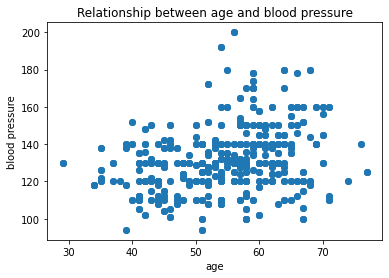

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("age")
plt.ylabel("blood pressure")

# define title
plt.title("Relationship between age and blood pressure")

# plot
plt.scatter(heart['age'], heart['blood pressure'])
plt.show()

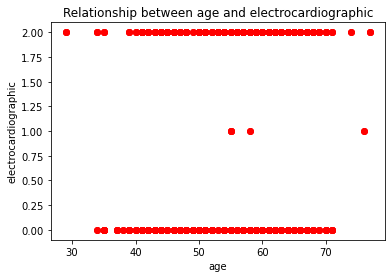

In [30]:
plt.xlabel("age")
plt.ylabel("electrocardiographic")

# define title
plt.title("Relationship between age and electrocardiographic")

# plot
plt.scatter(heart['age'], heart['electrocardiographic'], color = 'red')
plt.show()

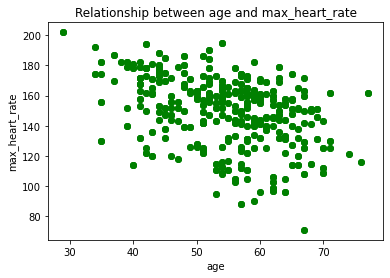

In [31]:
plt.xlabel("age")
plt.ylabel("max_heart_rate")

# define title
plt.title("Relationship between age and max_heart_rate")

# plot
plt.scatter(heart['age'], heart['max_heart_rate'], color = 'green')
plt.show()

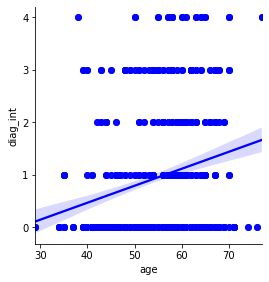

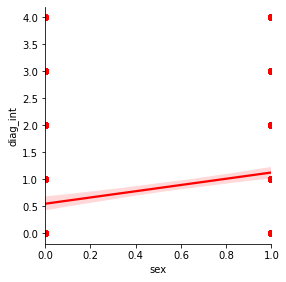

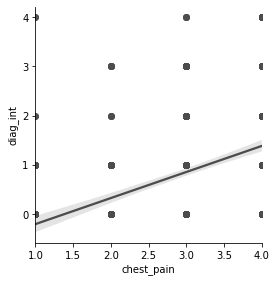

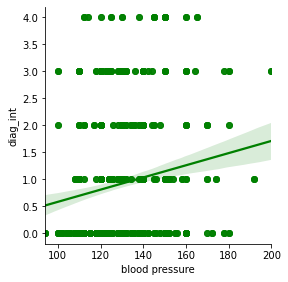

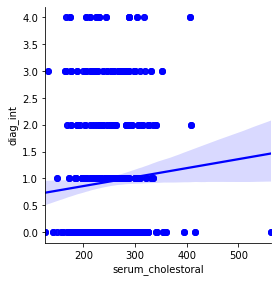

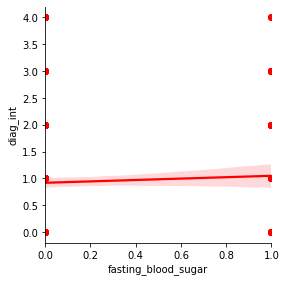

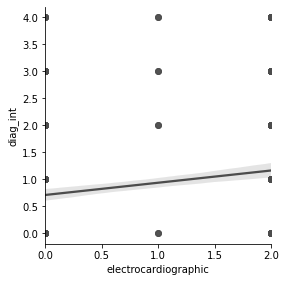

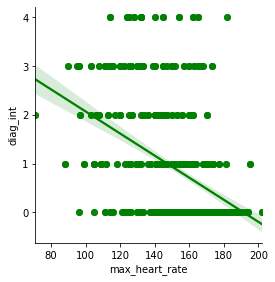

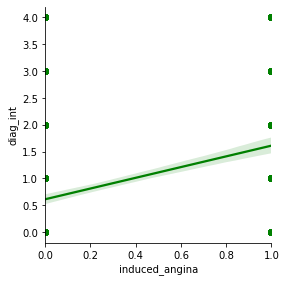

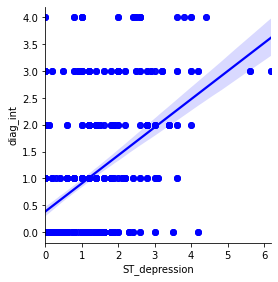

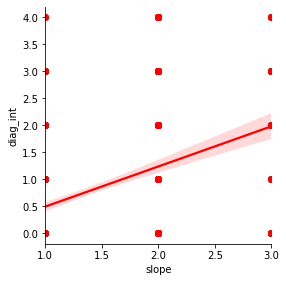

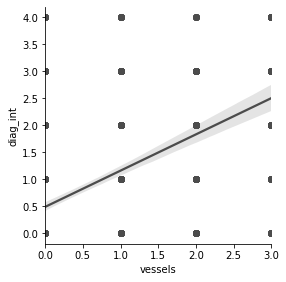

In [32]:
# search by the correlation between dependent variable and each feature

df = heart
g1 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["age"], size=4)
g1.map(sns.regplot, color="blue")

g2 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["sex"], size=4)
g2.map(sns.regplot, color="red")

g = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["chest_pain"], size=4)
g.map(sns.regplot, color="0.3")

gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["blood pressure"], size=4)
gg.map(sns.regplot, color="green")

g1 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["serum_cholestoral"], size=4)
g1.map(sns.regplot, color="blue")

g2 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["fasting_blood_sugar"], size=4)
g2.map(sns.regplot, color="red")

g = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["electrocardiographic"], size=4)
g.map(sns.regplot, color="0.3")

gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["max_heart_rate"], size=4)
gg.map(sns.regplot, color="green")

gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["induced_angina"], size=4)
gg.map(sns.regplot, color="green")

g1 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["ST_depression"], size=4)
g1.map(sns.regplot, color="blue")

g2 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["slope"], size=4)
g2.map(sns.regplot, color="red")

g = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["vessels"], size=4)
g.map(sns.regplot, color="0.3")

#gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["thal"], height=4)
#gg.map(sns.regplot, color="green")

In [33]:
def take_input(exists):
    inputs = []
    header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels']
    if exists:
        return 
    else :
        for n in range(0,13):
            print("Enter value for ",header_row[n])
            a = input()
            inputs.append(a)
        print(inputs)
        return inputs 

take_input(True)

In [34]:
# add parameters for grid search
loss = ["hinge", "log"]
penalty = ["l1", "l2"]
alpha = [0.1, 0.05, 0.01]
max_iter = [500, 1000]

# build the models with different parameters and select the best combination for the highest Accuracy
best_score = 0
best_param = (0,0,0,0)
for l in loss:
    for p in penalty:
        for a in alpha:
            for n in max_iter:
                print("Parameters for model", (l,p,a,n))
                lss = SGDClassifier(loss=l, penalty=p, alpha=a, max_iter=n)
                lss.fit(heart_train, goal_train)
                print("SGD Cross-Validation scores:")
                scores = model_selection.cross_val_score(lss, heart.loc[:,'age':'vessels'], heart.loc[:,'diagnosis'], cv=10)
                print (scores)
                print("SGD Cross-Validation score = ", np.mean(scores))
                
                if np.mean(scores) > best_score:
                    best_score = np.mean(scores)
                    best_param = (l,p,a,n)
                    
    
print("The best parameters for model are ", best_param)
print("The Cross-Validation score = ", best_score)


Parameters for model ('hinge', 'l1', 0.1, 500)
SGD Cross-Validation scores:
[0.32098765 0.6        0.425      0.5375     0.55       0.5
 0.5125     0.35       0.55       0.5125    ]
SGD Cross-Validation score =  0.48584876543209876
Parameters for model ('hinge', 'l1', 0.1, 1000)
SGD Cross-Validation scores:
[0.51851852 0.6125     0.6125     0.3625     0.25       0.575
 0.175      0.55       0.5375     0.575     ]
SGD Cross-Validation score =  0.4768518518518518
Parameters for model ('hinge', 'l1', 0.05, 500)
SGD Cross-Validation scores:
[0.2345679 0.2625    0.5875    0.3625    0.55      0.2       0.5875
 0.525     0.3625    0.1875   ]
SGD Cross-Validation score =  0.3859567901234568
Parameters for model ('hinge', 'l1', 0.05, 1000)
SGD Cross-Validation scores:
[0.58024691 0.5875     0.3625     0.5125     0.6125     0.1375
 0.6125     0.3375     0.3625     0.525     ]
SGD Cross-Validation score =  0.46302469135802476
Parameters for model ('hinge', 'l1', 0.01, 500)
SGD Cross-Validation sc

In [35]:
import pandas as pnd
def data_parsing(path):
    header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels','diagnosis']

    # read csv file with Cleveland heart diseases data
    heart = pnd.read_csv(path, names=header_row)
    
    # we have unknown values '?'
    # change unrecognized value '?' into mean value through the column
    for c in heart.columns[:-1]:
        heart[c] = heart[c].apply(lambda x: heart[heart[c]!='?'][c].astype(float).mean() if x == "?" else x)
        heart[c] = heart[c].astype(float)
        
    
    # map dependent variable y = "diagnosis" into binary label
    # if "diagnosis" == 0, member does not have disease A - we put 0
    # if "diagnosis" >= 1, member possess the disease A - we put 1

#     heart.loc[:, "diag_int"] = heart.loc[:, "diagnosis"].apply(lambda x: 1 if x >= 1 else 0)
    return heart


def subset_decomposition(data):
    # split dataset into train and test
    heart_train, heart_test, goal_train, goal_test = model_selection.train_test_split(data.loc[:,'age':'vessels'], \
                                                     data.loc[:,'diagnosis'], test_size=0.33, random_state=0)
    return heart_train, heart_test, goal_train, goal_test

def model_building(heart):
    # add parameters for grid search
    loss = ["hinge", "log"]
    penalty = ["l1", "l2"]
    alpha = [0.05, 0.01]
    n_iter = [500, 1000]
    heart_train, heart_test, goal_train, goal_test = subset_decomposition(heart)
    # build the models with different parameters and select the best combination for the highest Accuracy
    best_score = 0
    best_param = (0,0,0,0)
    for l in loss:
        for p in penalty:
            for a in alpha:
                for n in n_iter:
                    #print("Parameters for model", (l,p,a,n))
                    lss = SGDClassifier(loss=l, penalty=p, alpha=a, max_iter=n)
                    lss.fit(heart_train, goal_train)
                    #print("Linear regression SGD Cross-Validation scores:")
                    scores = model_selection.cross_val_score(lss, heart.loc[:,'age':'vessels'], heart.loc[:,'diagnosis'], cv=10)
                    #print scores
                    #print("Mean Linear regression SGD Cross-Validation score = ", np.mean(scores))

                    if np.mean(scores) > best_score:
                        best_score = np.mean(scores)
                        best_param = (l,p,a,n)


    print("The best parameters for model are ", best_param)
    print("The Cross-Validation score = ", best_score)

    # develop the model with the best parameters

    lss_best = SGDClassifier(loss='log', penalty='l1', alpha=0.05, max_iter=1000)
    data = data_parsing('New_Heart_disease.csv')
    # print(data[data.columns[0:-2]])
    heart_train, heart_test, goal_train, goal_test = model_selection.train_test_split(data.loc[:,'age':'vessels'], \
                                                     data.loc[:,'diagnosis'], test_size=0.33, random_state=1)
    lss_best.fit(heart_train, goal_train)
    print("SGD Test score:")
    print(lss_best.score(heart_test, goal_test))
    
   
    return lss_best

def self_prediction(heart_test, model):    
    # predict heart disease for test dataset
    y_pred_proba = model.predict_proba(heart_test)
    y_pred_proba = [x[1] for x in y_pred_proba]
    for i in y_pred_proba[:10]:
        print (i)
    return y_pred_proba



    
if __name__ == '__main__':
    heart = data_parsing('New_Heart_disease.csv')
    #model = model_building(heart)
    model_building(heart)

The best parameters for model are  ('log', 'l2', 0.05, 500)
The Cross-Validation score =  0.5655401234567901
SGD Test score:
0.5358490566037736


In [36]:
# develop the model with the best parameters

lss_best = SGDClassifier(alpha=0.05, fit_intercept=True, loss='log', max_iter=1000,
penalty='l1')
data = data_parsing('New_Heart_disease.csv')
#print(data[data.columns[0:-2]])
heart_train, heart_test, goal_train, goal_test = model_selection.train_test_split(data.loc[:,'age':'vessels'], \
                                                     data.loc[:,'diagnosis'], test_size=0.33, random_state=1)
lss_best.fit(heart_train, goal_train)
print("SGD Test score:")
print(lss_best.score(heart_test, goal_test))   

SGD Test score:
0.4226415094339623


Confusion matrix, without normalization
[[93  0  0 61  0]
 [10  0  0 38  0]
 [ 0  0  0 29  0]
 [ 1  0  0 19  0]
 [ 0  0  0 14  0]]


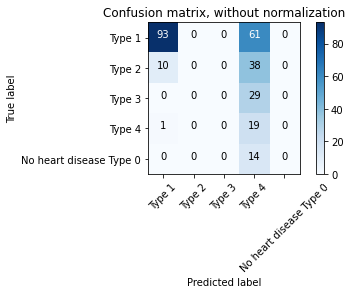

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(goal_test, lss_best.predict(heart_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Type 1","Type 2","Type 3","Type 4","No heart disease Type 0"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=["Heart disease Type 1","Type 2","Type 3","Type 4","No heart disease Type 0"], normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [38]:
# predict heart disease for test dataset
y_pred_proba = lss_best.predict_proba(heart_test)
y_pred_proba = [x[1] for x in y_pred_proba]
for i in y_pred_proba[:10]:
    print (i)

4.826081087889691e-09
1.4711611808453013e-08
5.445794035878673e-10
3.2096399020766882e-12
8.60541381048497e-06
2.3198864425538754e-06
5.1294188852855587e-11
2.1810339805360018e-10
1.5371743200473843e-08
8.077795711062434e-14


In [39]:
# predict heart disease for test dataset
y_pred = lss_best.predict(heart_test)
y_pred[:25]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3,
       3, 3, 3], dtype=int64)

In [40]:
test_df = pnd.DataFrame(heart_test, columns = header_row[:-1])

test_df.loc[:, "Disease_probability"] = [x[1] for x in lss_best.predict_proba(heart_test)]
test_df.to_excel("disease_probability.xlsx", index = False)
test_df[:5]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,Disease_probability
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,4.826081e-09
788,51.0,1.0,4.0,140.0,298.0,0.0,0.0,122.0,1.0,4.2,2.0,3.0,1.471161e-08
570,71.0,0.0,4.0,112.0,149.0,0.0,0.0,125.0,0.0,1.6,2.0,0.0,5.445794e-10
224,47.0,1.0,4.0,112.0,204.0,0.0,0.0,143.0,0.0,0.1,1.0,0.0,3.209640e-12
496,59.0,1.0,1.0,160.0,273.0,0.0,2.0,125.0,0.0,0.0,1.0,0.0,8.605414e-06


In [41]:
# print weights for each X_k from the built  LSS model
w = lss_best.coef_[0]
a = -w[0] / w[1]
print ("Weight Coefficients")
coeff_df = pnd.DataFrame(columns = ['X_k', 'coeff'])
for c in range(len(heart.loc[:,'age':'vessels'].columns)):
    coeff_df.loc[len(coeff_df)] = [heart.loc[:,'age':'vessels'].columns[c], w[c]]
    
coeff_df

Weight Coefficients


,X_k,coeff
0,age,0.557932
1,sex,-2.684780
2,chest_pain,-16.274380
3,blood pressure,-0.229615
4,serum_cholestoral,0.000000
5,fasting_blood_sugar,0.000000
6,electrocardiographic,0.000000
7,max_heart_rate,0.508368
8,induced_angina,0.000000
9,ST_depression,-11.047044


In [45]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
data = data_parsing('New_Heart_disease.csv')
# print(data[data.columns[0:-2]])
heart_train, heart_test, goal_train, goal_test = model_selection.train_test_split(data.loc[:,'age':'vessels'], \
                                                     data.loc[:,'diagnosis'], test_size=0.33, random_state=1)
nb.fit(heart_train,goal_train)

Y_pred_nb = nb.predict(heart_test)
print(Y_pred_nb)

[1 3 0 0 1 3 1 1 4 1 0 0 1 0 0 0 4 0 0 0 0 2 1 0 2 0 0 1 0 0 0 1 0 0 2 0 0
 1 2 1 4 0 1 1 0 3 0 0 3 3 0 0 2 0 3 0 1 0 3 3 1 0 0 2 1 2 0 0 3 0 0 3 0 3
 1 3 0 1 0 0 0 1 0 1 1 0 0 0 2 1 3 0 0 0 0 0 0 0 1 1 0 1 3 2 1 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 2 0 3 1 0 1 0 3 1 0 1 0 3 2 3 0 0 2 3 0 1 1 0 0 0 0 3
 0 0 0 2 0 0 0 0 1 3 3 0 3 0 3 3 3 0 0 1 0 3 0 0 0 0 4 0 0 0 0 1 1 2 0 1 2
 0 1 1 1 0 0 0 1 3 1 0 1 0 1 2 0 0 1 0 0 0 0 0 2 1 0 2 0 3 0 0 0 3 3 3 3 0
 0 0 4 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3 4 0 0 0 0 1 0 0 0 0 0 2 0 0 0 3 1 0
 1 2 0 0 0 0]


Confusion matrix, without normalization
[[130  17   5   1   1]
 [ 16  19   3   9   1]
 [  3   7   5  11   3]
 [  2   5   8   5   0]
 [  0   3   1   9   1]]


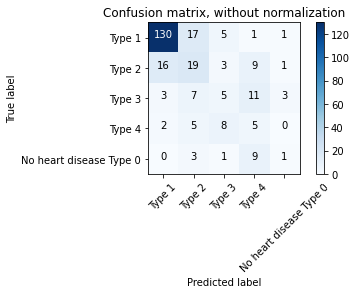

In [46]:
# Compute confusion matrix
cf_matrix = confusion_matrix(goal_test, nb.predict(heart_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cf_matrix, classes=["Type 1","Type 2","Type 3","Type 4","No heart disease Type 0"],
                      title='Confusion matrix, without normalization')
plt.show()

In [47]:
#random forest

from sklearn.ensemble import RandomForestClassifier
rdt = RandomForestClassifier()
data = data_parsing('New_Heart_disease.csv')
heart_train, heart_test, goal_train, goal_test = model_selection.train_test_split(data.loc[:,'age':'vessels'], \
                                                     data.loc[:,'diagnosis'], test_size=0.33, random_state=1)
rdt.fit(heart_train,goal_train)
y_hats = rdt.predict(heart_test)

Confusion matrix, without normalization
[[154   0   0   0   0]
 [  4  38   6   0   0]
 [  2   0  27   0   0]
 [  0   0   0  20   0]
 [  0   0   0   0  14]]


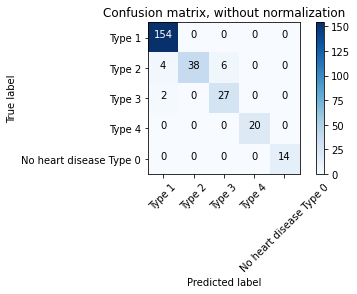

In [48]:
# Compute confusion matrix
cf_matrix = confusion_matrix(goal_test, rdt.predict(heart_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cf_matrix, classes=["Type 1","Type 2","Type 3","Type 4","No heart disease Type 0"],
                      title='Confusion matrix, without normalization')
plt.show()

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [50]:
print("Random forest")
score=round(accuracy_score(goal_test, y_hats)*100,2)
print(classification_report(goal_test, y_hats))

Random forest
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       154
           1       1.00      0.79      0.88        48
           2       0.82      0.93      0.87        29
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        14

    accuracy                           0.95       265
   macro avg       0.96      0.94      0.95       265
weighted avg       0.96      0.95      0.95       265



In [51]:
scores = [score]
algorithms = ["Random Forest"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

The accuracy score achieved using Random Forest is: 95.47 %


In [52]:
#random forest
def take_input(exists):
    inputs = []
    header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels']
    if exists:
        return 
    else :
        for n in range(0,12):
            print("Enter value for ",header_row[n])
            a = input()
            inputs.append(a)
        print("\n",inputs)
        inputs = np.expand_dims(inputs, axis=0)
        df_inputs = pnd.DataFrame(inputs, columns = header_row)
        #print("data",df_inputs)
        return df_inputs 

#user_inputs = user_inputs.reshape(1,len(user_inputs))
    
user_inputs = take_input(0)
p=rdt.predict(user_inputs)
#c= random.choice(p)
c=p
if(c==0):
    print("\nPatient doesnt have heart disease")
elif(c==1):
    print("\nPatient has heart disease type 1")
elif(c==2):
    print("\nPatient has heart disease type 2")
elif(c==3):
    print("\nPatient has heart disease type 3")
else:
    print("\nPatient has heart disease type 4")
    
# predict heart disease for test dataset
#y_pred_proba = rdt.predict_proba(user_inputs)
#y_pred_proba = [x[1] for x in y_pred_proba]
#print("\nThe probability of the patient having disease is", y_pred_proba[0])


Enter value for  age
34
Enter value for  sex
3
Enter value for  chest_pain
4
Enter value for  blood pressure
54
Enter value for  serum_cholestoral
54
Enter value for  fasting_blood_sugar
54
Enter value for  electrocardiographic
43
Enter value for  max_heart_rate
3
Enter value for  induced_angina
3
Enter value for  ST_depression
33
Enter value for  slope
4
Enter value for  vessels
4

 ['34', '3', '4', '54', '54', '54', '43', '3', '3', '33', '4', '4']

Patient has heart disease type 3
